<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/MachineIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#copyright joshuah.rainstar@gmail.com 2025 TG skymasterskymaster
#some code borrowed from karapathy's nanogpt, pytorch.
#nanogpt copyright karapathy, code used = insubstantial
#All glory to the Messiah, Christ the King

from __future__ import annotations
import math
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


_phase_idx_cache = {}  # (device, T, S) -> idx [1, S-1, T, 1]

def _get_phase_idx(device, T: int, num_segs: int) -> torch.Tensor:
    key = (device, T, num_segs)
    idx = _phase_idx_cache.get(key)
    if idx is None or idx.device != device:
        L = torch.arange(1, num_segs, device=device, dtype=torch.long)   # [S-1]
        t = torch.arange(T, device=device, dtype=torch.long)              # [T]
        src = (t.unsqueeze(0) - L[:, None]).clamp_min(0)                  # [S-1, T]
        idx = src.view(1, num_segs - 1, T, 1)                             # [1,S-1,T,1]
        _phase_idx_cache[key] = idx
    return idx


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

def add_hypersphere_phase_heads_cached(
    x: torch.Tensor, num_segs: int, eps: float = 1e-8, return_scalar: bool = False
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return (x, None) if return_scalar else x
    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    seg_size = C // num_segs
    xh = x.view(B, T, num_segs, seg_size).transpose(1, 2)                  # [B,S,T,E]
    if num_segs > 1:
        v = F.normalize(xh[:, 1:], dim=-1, eps=eps)                        # [B,S-1,T,E]
        idx = _get_phase_idx(x.device, T, num_segs)                        # [1,S-1,T,1]
        anchor = v.gather(2, idx.expand(B, num_segs-1, T, seg_size))       # [B,S-1,T,E]
        cosA = (v * anchor).sum(dim=-1).clamp(-1.0 + eps, 1.0 - eps)       # [B,S-1,T]
        xproc = xh[:, 1:] + (cosA / float(seg_size)).unsqueeze(-1)         # [B,S-1,T,E]
        xh = torch.cat([xh[:, :1], xproc], dim=1)
    y = xh.transpose(1, 2).contiguous().view(B, T, C)

    if not return_scalar:
        return y

    # lag-1 scalar across heads-as-coordinate
    epsv = eps
    v_all = F.normalize(xh, dim=-1, eps=epsv)                              # [B,S,T,E]
    t_idx = torch.arange(T, device=x.device)
    t_prev = (t_idx - 1).clamp_min(0)
    idx_prev_time = t_prev.view(1, 1, T, 1).expand(B, num_segs, T, v_all.size(-1))
    anchor_all = v_all.gather(2, idx_prev_time)                            # [B,S,T,E]
    cos_lag1_heads = (v_all * anchor_all).sum(dim=-1).clamp(-1.0 + epsv, 1.0 - epsv)  # [B,S,T]
    s_norm = F.normalize(cos_lag1_heads, dim=1, eps=epsv)                  # [B,S,T]
    idx_prev_s = t_prev.view(1, 1, T).expand(B, num_segs, T)
    s_anchor = torch.gather(s_norm, dim=2, index=idx_prev_s)               # [B,S,T]
    scalar_1d = (s_norm * s_anchor).sum(dim=1).clamp(-1.0 + epsv, 1.0 - epsv)         # [B,T]
    return y, scalar_1d


class PhaseHeads(nn.Module):
    def __init__(self, num_segs, eps=1e-8):
        super().__init__()
        self.s, self.eps = num_segs, eps
    def forward(self, x):
        y, scalar_1d = add_hypersphere_phase_heads_cached(x, self.s, self.eps, return_scalar=True)
        return y, scalar_1d  # y: [B,T,C], scalar_1d: [B,T]

class Router1DGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Linear(1, 4, bias=True)
        self.gru = nn.GRU(input_size=4, hidden_size=16, num_layers=3, batch_first=True, bias=True)
        self.down = nn.Linear(16, 1, bias=False)  # see ?1
    def forward(self, s1d: torch.Tensor) -> torch.Tensor:
        # s1d: [B,T] or [B,T,1]
        if s1d.dim() == 2:
            s1d = s1d.unsqueeze(-1)        # [B,T,1]
        z = self.up(s1d)                   # [B,T,4]
        y, _ = self.gru(z)                 # y: [B,T,16]
        y = self.down(y).squeeze(-1)       # [B,T]
        return y

def circular_student_t(center: torch.Tensor, E: int, v: float) -> torch.Tensor:
    # center: [B,T], returns weights [B,T,E]
    B, T = center.shape
    device = center.device
    idx = torch.arange(E, device=device, dtype=center.dtype).view(1, 1, E)  # [1,1,E]
    c = center.unsqueeze(-1)  # [B,T,1]
    # wrap center to [0, E)
    c = c - torch.floor(c / E) * E  # modulo for reals
    delta = torch.abs(idx - c)                        # [B,T,E]
    d = torch.minimum(delta, float(E) - delta)        # circular distance
    w = torch.pow(1.0 + (d * d) / v, -0.5 * (v + 1.0))  # Student's t pdf up to constant
    w = w / (w.sum(dim=-1, keepdim=True) + 1e-12)
    return w  # [B,T,E]

class MOEMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_experts = config.n_head
        self.router = Router1DGRU()
        self.experts = nn.ModuleList([MLP(config) for _ in range(self.num_experts)])
        self.v = math.e

    def forward(self, x: torch.Tensor, scalar_1d: torch.Tensor) -> torch.Tensor:
        # x: [B,T,C], scalar_1d: [B,T]
        center = self.router(scalar_1d)                   # [B,T]
        weights = circular_student_t(center, self.num_experts, self.v)  # [B,T,E]
        # run experts
        outs = [expert(x) for expert in self.experts]     # list of [B,T,C]
        y = torch.stack(outs, dim=2)                      # [B,T,E,C]
        w = weights.unsqueeze(-1)                         # [B,T,E,1]
        y = (w * y).sum(dim=2)                            # [B,T,C]
        return y


def add_hypersphere_complex_phase_heads(
    x: torch.Tensor,
    num_segs: int,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Non-cached, complex-safe version.
    x: [B, T, C] (real or complex)
    returns y: [B, T, C] (same dtype as x)
    """
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return x
    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    E = C // num_segs

    # reshape into [B, S, T, E]
    xh = x.view(B, T, num_segs, E).transpose(1, 2)

    if num_segs > 1:
        # complex-safe L2 normalize along the last dim
        def _cnorm(z: torch.Tensor, dim: int, eps: float) -> torch.Tensor:
            denom = torch.linalg.vector_norm(z, ord=2, dim=dim, keepdim=True).clamp_min(eps)
            return z / denom

        v = _cnorm(xh[:, 1:], dim=-1, eps=eps)  # [B, S-1, T, E]

        # per-seg lag index (lag = seg id), shape [1, S-1, T, 1]
        L = torch.arange(1, num_segs, device=x.device, dtype=torch.long)  # [S-1]
        t = torch.arange(T, device=x.device, dtype=torch.long)            # [T]
        src = (t.unsqueeze(0) - L[:, None]).clamp_min(0)                  # [S-1, T]
        idx = src.view(1, num_segs - 1, T, 1).expand(B, num_segs - 1, T, E)

        # gather anchors and form complex inner product with conjugation
        anchor = v.gather(dim=2, index=idx)                               # [B, S-1, T, E]
        cosA = (v * anchor.conj()).sum(dim=-1)                            # [B, S-1, T], complex

        # add complex scalar field back across feature dim
        xproc = xh[:, 1:] + (cosA / float(E)).unsqueeze(-1)               # [B, S-1, T, E]
        xh = torch.cat([xh[:, :1], xproc], dim=1)

    y = xh.transpose(1, 2).contiguous().view(B, T, C)
    return y


class Mixer(nn.Module):
    def __init__(self, config, eps=1e-16, dw_kernel=7):  # dw_kernel=7 ?1
        super().__init__()
        self.emb = config.n_embd
        self.segs = config.n_head
        self.eps = eps
        self.dwk = dw_kernel
        # depthwise causal conv over time for optional local mixing
        self.dw = nn.Conv1d(
            in_channels=self.emb, out_channels=self.emb, kernel_size=3, groups=self.emb, bias=False
        )  # placeholder to show shape, see note below

    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,T,C], real
        B, T, C = x.shape

        x32 = x.float()
        Y = torch.fft.fft(x32, dim=2)  # channel-only FFT, preserves time causality
        S = add_hypersphere_complex_phase_heads(Y, self.segs, self.eps)
        Z = torch.fft.ifft(S, dim=2).real  # still [B,T,C]
        # causal time mixing: depthwise Conv1d with left padding
        k = self.dw.kernel_size[0]
        Zt = Z.transpose(1, 2)                                # [B,C,T]
        Zc = self.dw(F.pad(Zt, (k - 1, 0)))                   # [B,C,T]
        out = Zc.transpose(1, 2).to(x.dtype)                  # [B,T,C]
        return out

class BlockFast(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.moe  = MOEMLP(config)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.phase = PhaseHeads(self.n_head)
        self.attn = Mixer(config)
        self.lags = choose_lags(config.n_embd,config.block_size)

    def forward(self, x):
        x_attn  = self.attn(x)
        x_phase, scalar_1d = self.phase(x_attn)     # scalar_1d: [B,T]
        x= x + x_phase + self.moe(x_phase, scalar_1d)
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 2
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wpe = nn.Embedding(config.block_size, config.n_embd),
            wte =  nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([BlockFast(config) for _ in range(config.n_layer)]),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())

        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= (self.config.block_size), (f"Cannot forward seq len {t}; max is block_size={self.config.block_size}")
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = self.transformer.wte(idx)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        # Get shared constants for this sequence length
        for block in self.transformer.h:
            x = block(x)  # recompute activations on backward

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

/tmp/ipython-input-740599716.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [ ]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [ ]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=64,
    n_head=16,
    dropout=0.1,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)


model = model.to(device)



number of parameters: 3.25M


In [ ]:
#print model params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 3253584


In [ ]:
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

5.638319969177246
5.112461090087891
4.703266143798828
4.3812055587768555
4.094568252563477
3.875481605529785
3.6215057373046875
3.4757628440856934
3.3854434490203857
3.3624634742736816
3.290637969970703
3.3229713439941406
3.2876737117767334
3.2252354621887207
3.1476073265075684
3.1058695316314697
3.0371646881103516
3.010706663131714
3.005967140197754
2.9248056411743164
2.893735885620117
2.915337562561035
2.845219850540161
2.80903959274292
2.790475606918335
2.7456390857696533
2.7324235439300537
2.7223422527313232
2.6719510555267334
2.644369602203369
2.5937228202819824
2.61458683013916
2.594435691833496
2.6068737506866455
2.5727734565734863
2.5844666957855225
2.582608461380005
2.550192356109619
2.4609742164611816
2.5383949279785156
2.502096652984619
2.5154879093170166
2.500417947769165
2.481484889984131
2.4761288166046143
2.4843578338623047
2.4491279125213623
2.4644064903259277
2.3832473754882812
2.4260687828063965
2.379568576812744
2.395585775375366
2.3964781761169434
2.39992618560791
2

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


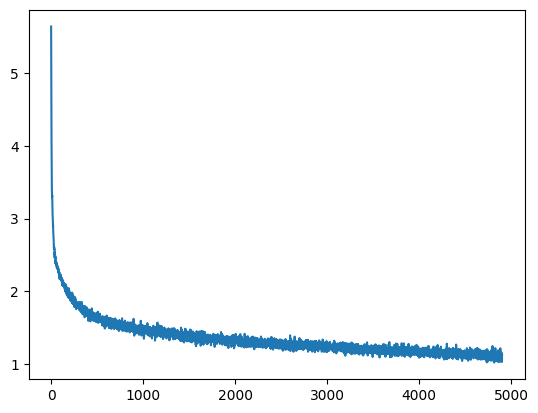

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = 0#int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))

val   CE: 1.6703824931383133


In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO! ROMEO! ROMEO!"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)


ROMEO! ROMEO! ROMEO!

BAUWISTAND:
It is an else wench you, as you will hence.

DUKE OF AUMERLE:
God do not, Juliet, that incapable from
Such a dozens with an high report that make from
Thy ears more than thou hast not amain.
Be so, a groan, that's your son come upon.
The swill too death.

Second Servingman:
Is thy noble crime is no rest,
And that once may seem of a track my house,
I warrants see him by the redless centre
Whateful serving to this dead before him,
Have me with look'd of my own means thy speech:
Where are thou delight thee and so flowers fast!

KING RICHARD III:
O banished so foul crown, or else he shall be thou
Are we no pluck in a second commanded up,
And let me I will fly that I pawn my good;
Who all this all: remember seat, but you sword,
In pity to the equal the matterity of that
Which else you will I wot for his son.

CAPULET:
He hather!
Hadst to thy virtuous and his nobles
I let be not so murder, not rain'd my lame,
We come again to be thus it pleaseth needful.

CA

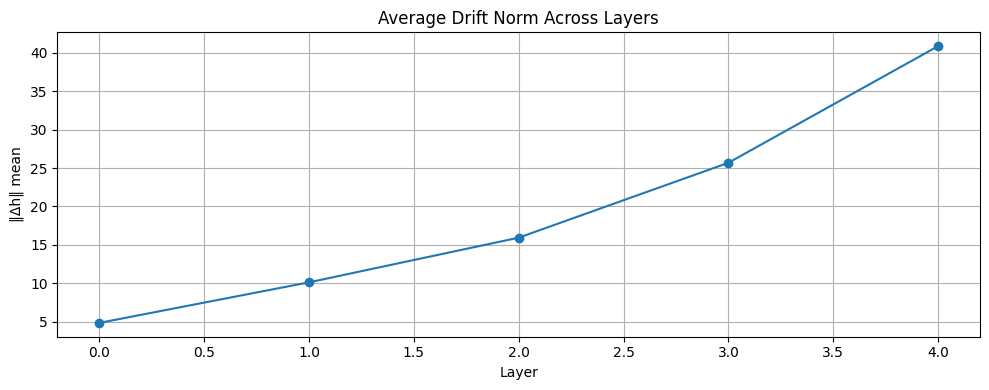

Jacobian rank (final token, projected): 56


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb + pos_emb)  # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = model.transformer.wte(tok)
    emb = (tok_emb + pos_emb).requires_grad_(True)

    def forward_emb(emb_input):
        x = model.transformer.drop(emb_input)
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.transformer.wpe(pos)  # [T_all, C]
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb + pos_emb)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


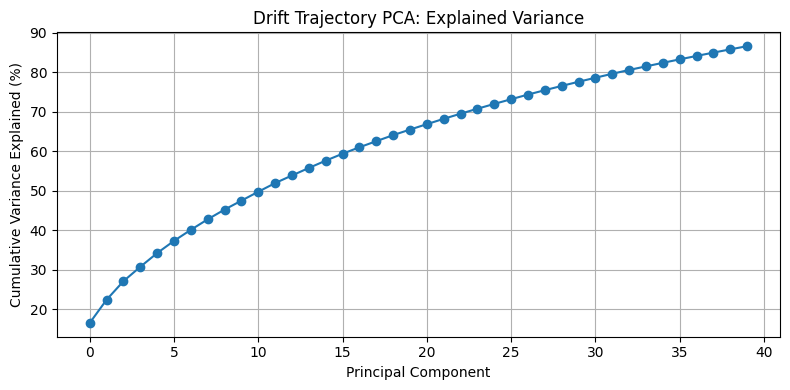

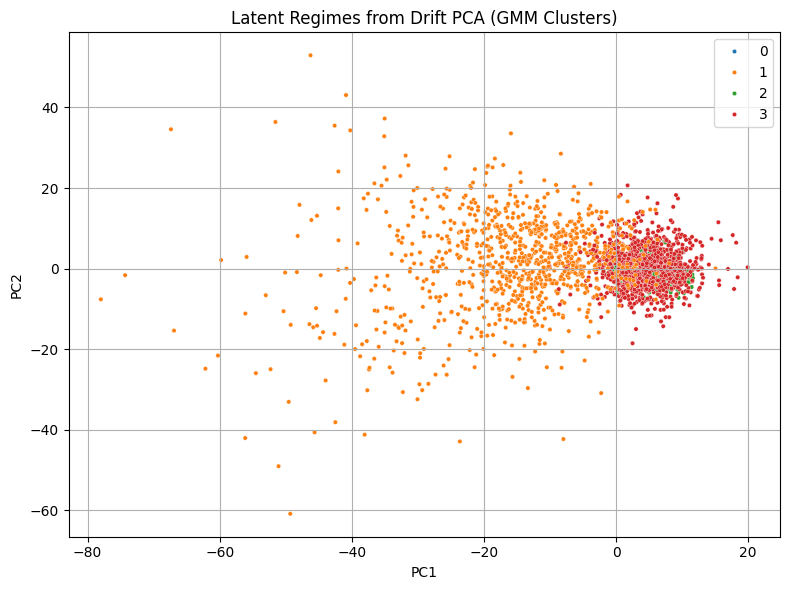

In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


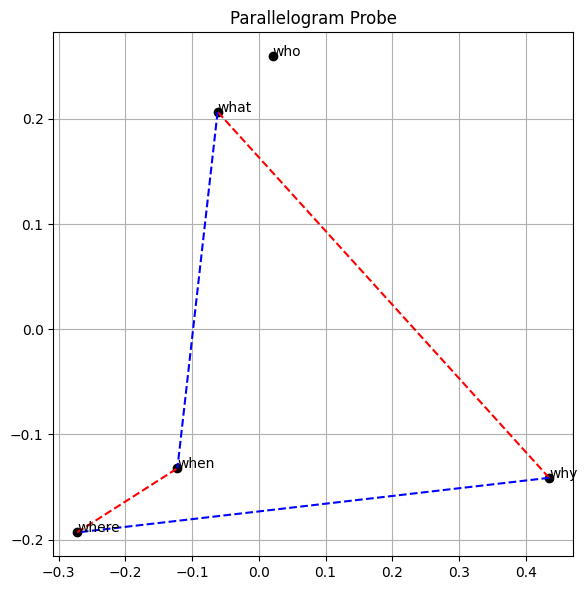


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


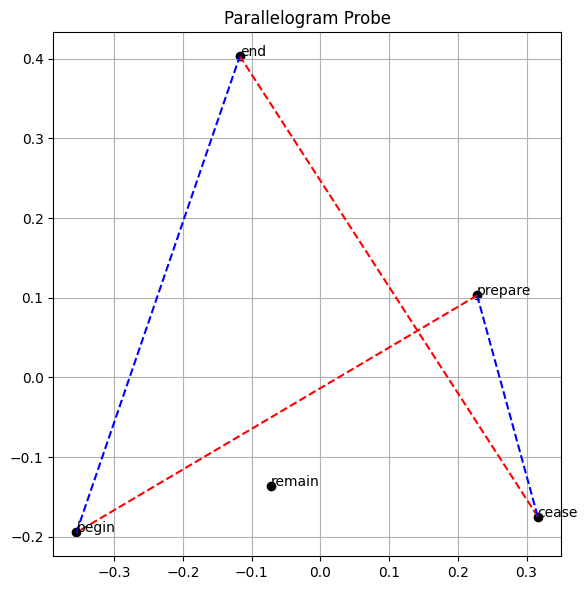


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


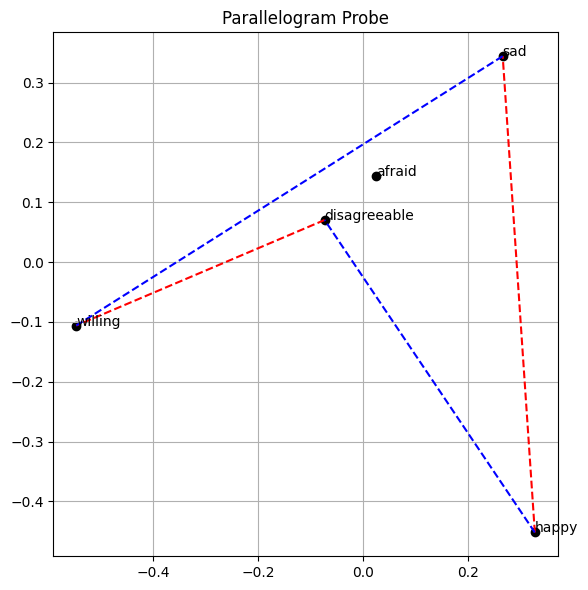


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


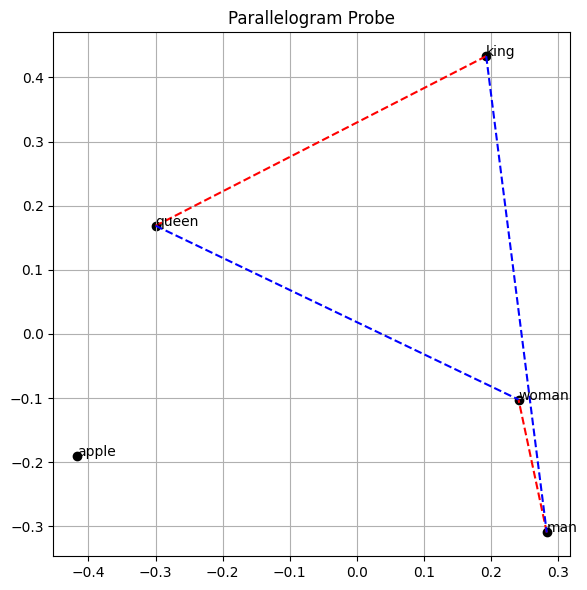


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


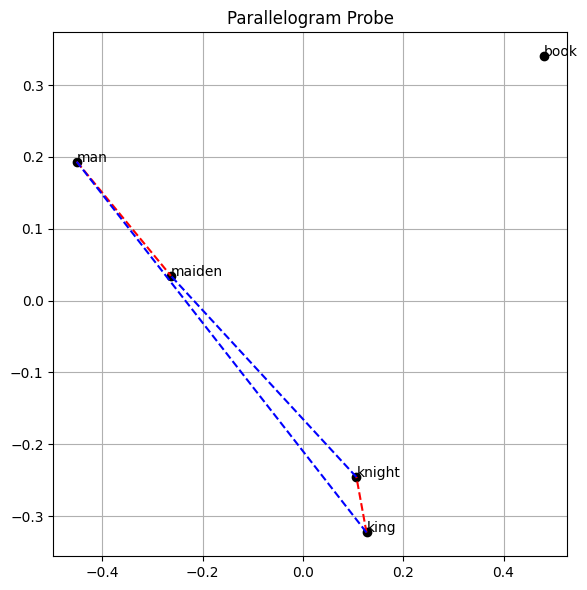


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


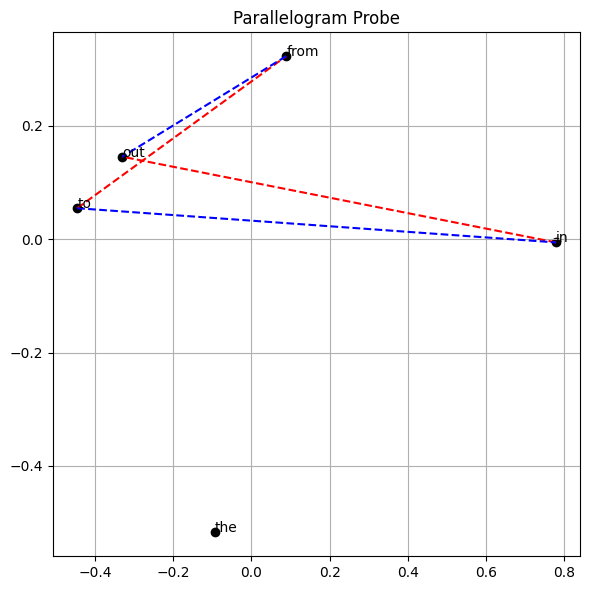

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0)
        #emb = torch.cat(model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0), dim=-1)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


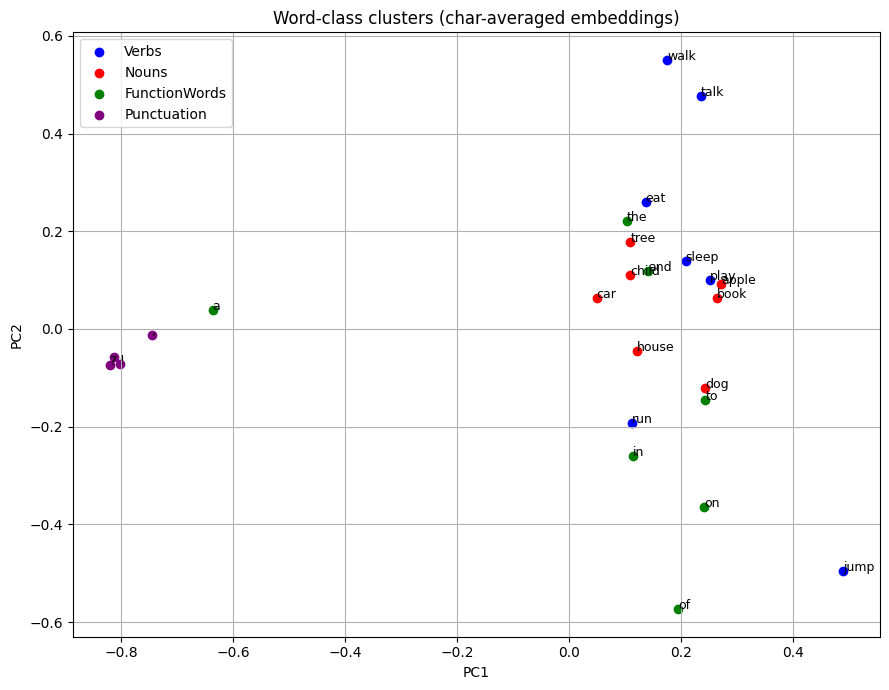

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)